# 1. Import Packages

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
import matplotlib.image as mpimg

 # 2. Load Data

In [2]:
## Download Data
import gdown
!gdown https://drive.google.com/uc?id=1T0S6xciAhG-o_385lHwnrBs0nNZFJC4I

Downloading...
From (original): https://drive.google.com/uc?id=1T0S6xciAhG-o_385lHwnrBs0nNZFJC4I
From (redirected): https://drive.google.com/uc?id=1T0S6xciAhG-o_385lHwnrBs0nNZFJC4I&confirm=t&uuid=cf04f2a2-15f0-4ef0-87ec-1268d3b80d21
To: /content/apparel.zip
100% 260M/260M [00:07<00:00, 32.7MB/s]


In [3]:
## Extract Data
import zipfile

local_zip = '/content/apparel.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/Apparel')
zip_ref.close()

In [4]:
!pip install split_folders

In [5]:
## split to train and test
import splitfolders
splitfolders.ratio('/tmp/Apparel',
                   output = '/tmp/data',
                   seed = 1,
                   ratio = (0.8,0.2))

Copying files: 11385 files [00:01, 5913.19 files/s]


## 2.1. ImageDataGenerator
prepare untuk preprocessing pada image seperti yang kita lakukan di data augmentation

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1)

test_datagen  = ImageDataGenerator(rescale=1./255)

## 2.2. Data Flow

In [7]:
## pretrained model yang akan kita pakai memiliki input size (224,224)
size = (224,224)

train_generator = train_datagen.flow_from_directory('/tmp/data/train',
                                                    target_size=size,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical')


test_generator  = test_datagen.flow_from_directory('/tmp/data/val',
                                                    target_size=size,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical')

Found 9101 images belonging to 24 classes.
Found 2284 images belonging to 24 classes.


In [8]:
target_names = list(train_generator.class_indices.keys())

## Visualisasi Gambar

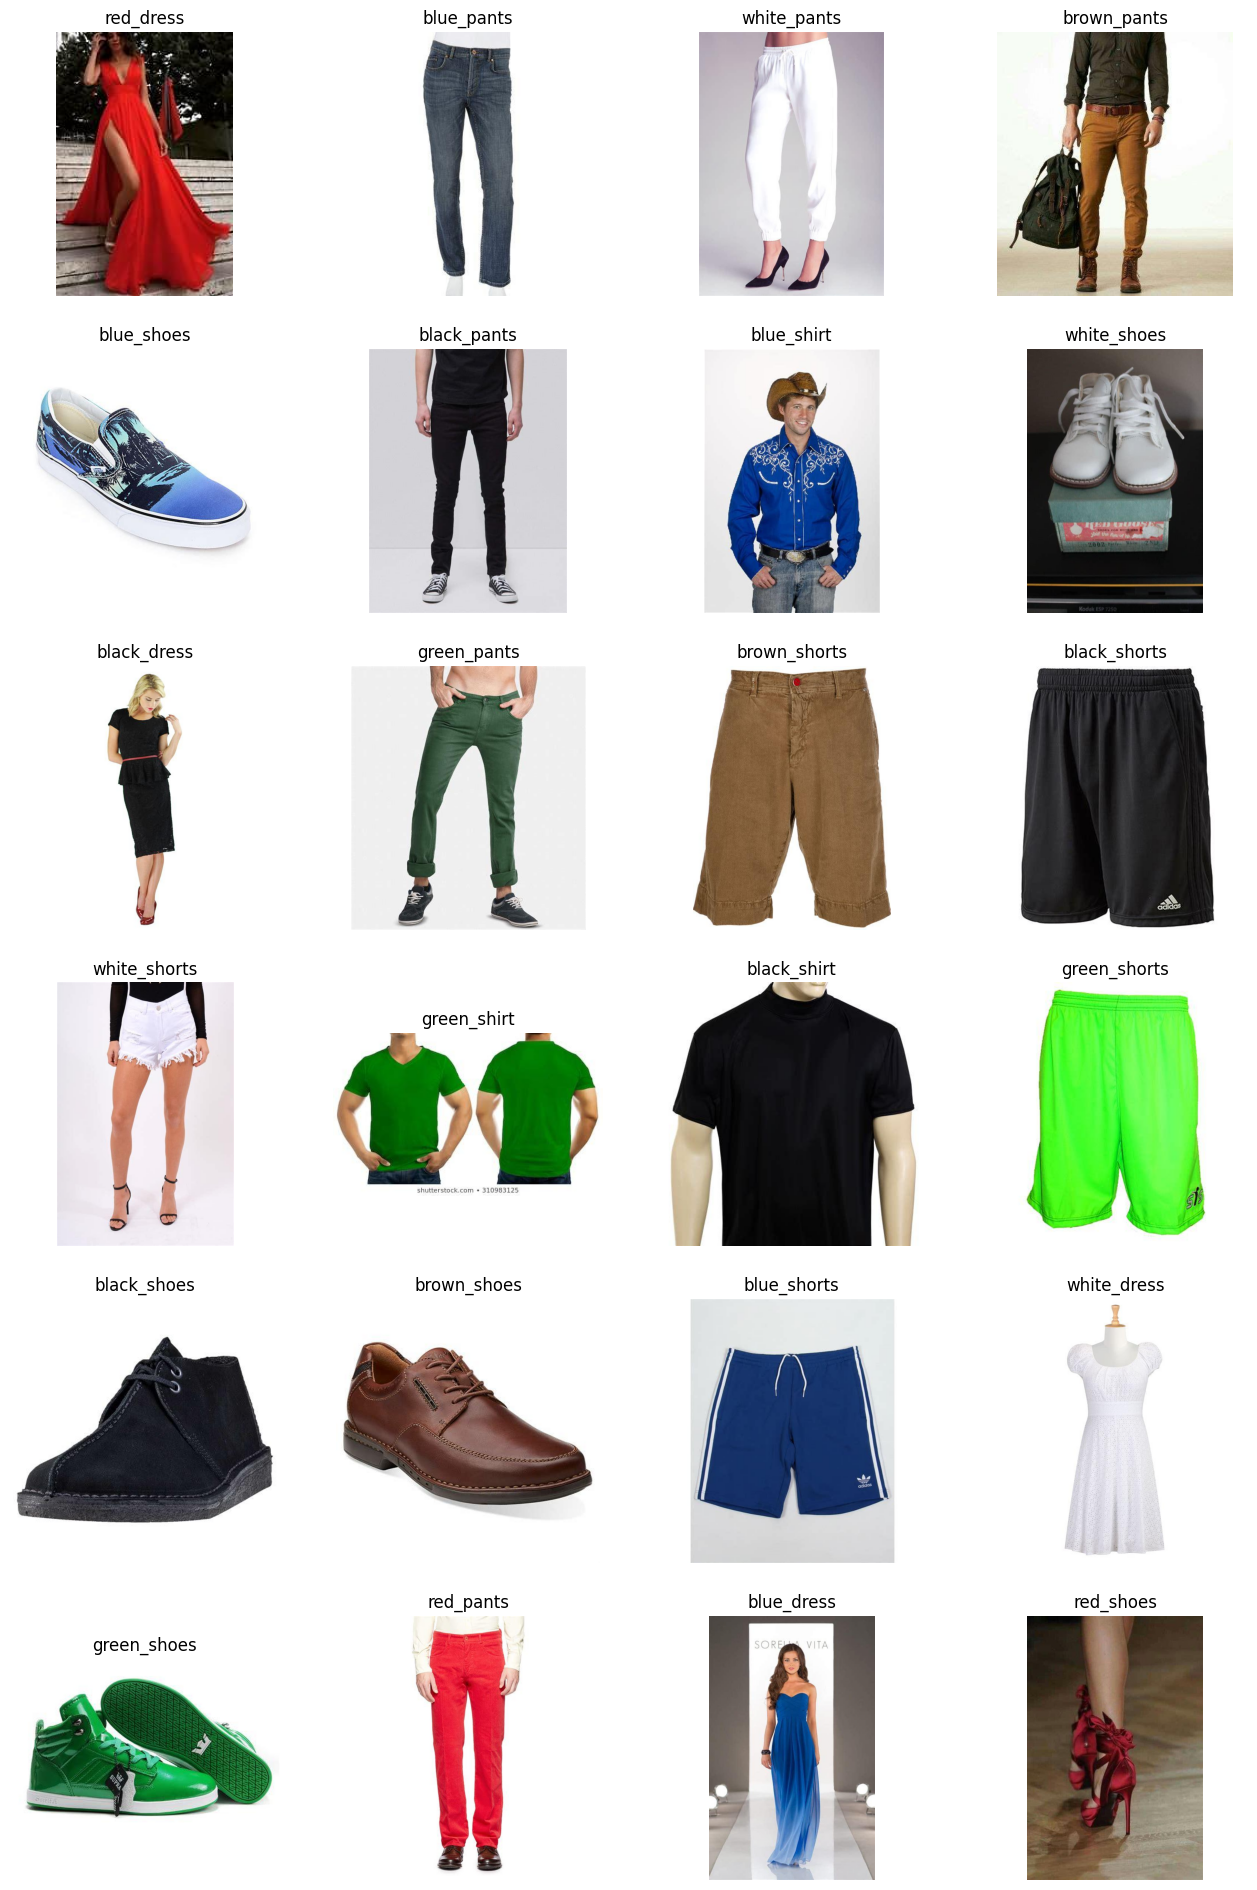

In [9]:
import os
kategori = os.listdir('/tmp/Apparel')
value    = [len(os.listdir('/tmp/Apparel/' + folder)) for folder in kategori]

fig, ax = plt.subplots(nrows=6, ncols=4,figsize = (16,24))

i = 0
for j in range(6):
  for k in range(4):
    path = "/tmp/Apparel/" + kategori[i]
    list_gambar = os.listdir(path)

    indeks = np.random.randint(value[i])

    img = mpimg.imread(path + "/" + list_gambar[indeks])
    ax[j,k].imshow(img)
    ax[j,k].set_title(kategori[i])
    ax[j,k].axis('off')

    i += 1

# 3. Build CNN Architecture

## 3.1. Model Architecture

Note in using Pretrained Model :
1. Karena kita memakai model yang ditrained orang, maka kita harus ikuti aturan yang diterapkan, seperti mengetahui input size. Mostly, pretrained model for image memakai `input_size = (224,224,3)`.
2. Ketahui output size-nya. Mostly, output sizenya adalah 1000 neuron, karena ditrained ke data dengan 1000 class.
3. Pastikan kita menambah output layer terakhir dengan jumlah class yang mau kita predict.

Untuk pon (1)-(2), pastikan kembali ke dokumentasi modelnya.

In [10]:
import tensorflow_hub as hub
model_source  = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [17]:
model = tf.keras.Sequential([

    ## Pretrained Model
    tf.keras.layers.MaxPool2D((1,1),padding = 'same'),
    hub.KerasLayer(model_source,trainable=False),

    ## Custom Model
    tf.keras.layers.Dense(24,activation="softmax")])

## 3.2. Optimizer

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
              metrics=['accuracy'])
model.build([None,224, 224, 3])

## 3.3. Summary

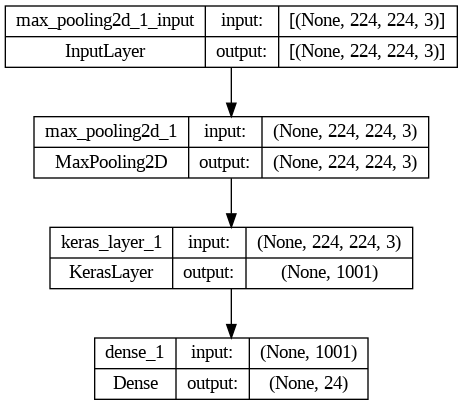

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_1 (MaxPoolin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 24)                24048     
                                                                 
Total params: 5456761 (20.82 MB)
Trainable params: 24048 (93.94 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


# 4. Training

In [21]:
import time

In [22]:
start_time = time.time()

trained_model = model.fit(train_generator,
                          epochs=15,
                          validation_data = test_generator )


end_time   = time.time()
duration   = np.round((end_time - start_time)/60,2)
print("\nTime Elapsed for training model : ",duration,"minutes.")

Epoch 1/15
285/285 [==============================] - 126s 427ms/step - loss: 1.8031 - accuracy: 0.5013 - val_loss: 0.9377 - val_accuracy: 0.7220
Epoch 2/15
285/285 [==============================] - 123s 431ms/step - loss: 0.7530 - accuracy: 0.7789 - val_loss: 0.6379 - val_accuracy: 0.8074
Epoch 3/15
285/285 [==============================] - 120s 421ms/step - loss: 0.5398 - accuracy: 0.8438 - val_loss: 0.5173 - val_accuracy: 0.8472
Epoch 4/15
285/285 [==============================] - 121s 425ms/step - loss: 0.4460 - accuracy: 0.8696 - val_loss: 0.4623 - val_accuracy: 0.8538
Epoch 5/15
285/285 [==============================] - 125s 439ms/step - loss: 0.3829 - accuracy: 0.8884 - val_loss: 0.4312 - val_accuracy: 0.8581
Epoch 6/15
285/285 [==============================] - 126s 441ms/step - loss: 0.3445 - accuracy: 0.8996 - val_loss: 0.3941 - val_accuracy: 0.8739
Epoch 7/15
285/285 [==============================] - 126s 442ms/step - loss: 0.3162 - accuracy: 0.9083 - val_loss: 0.3789 -

# 5. Model Performance

## 5.1. Accuracy and Loss

In [23]:
print("Model Performance on Data Train")
loss,acc = model.evaluate_generator(train_generator)
print(f"Loss     : {np.round(loss,2)}")
print(f"Accuracy : {np.round(acc,2)}")

print("\nModel Performance on Data Testing")
loss,acc = model.evaluate_generator(test_generator)
print(f"Loss     : {np.round(loss,2)}")
print(f"Accuracy : {np.round(acc,2)}")

Model Performance on Data Train


<ipython-input-23-abe1e9b86a5c>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss,acc = model.evaluate_generator(train_generator)


Loss     : 0.2
Accuracy : 0.94

Model Performance on Data Testing


<ipython-input-23-abe1e9b86a5c>:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss,acc = model.evaluate_generator(test_generator)


Loss     : 0.32
Accuracy : 0.89


## 5.2. Model Performance History

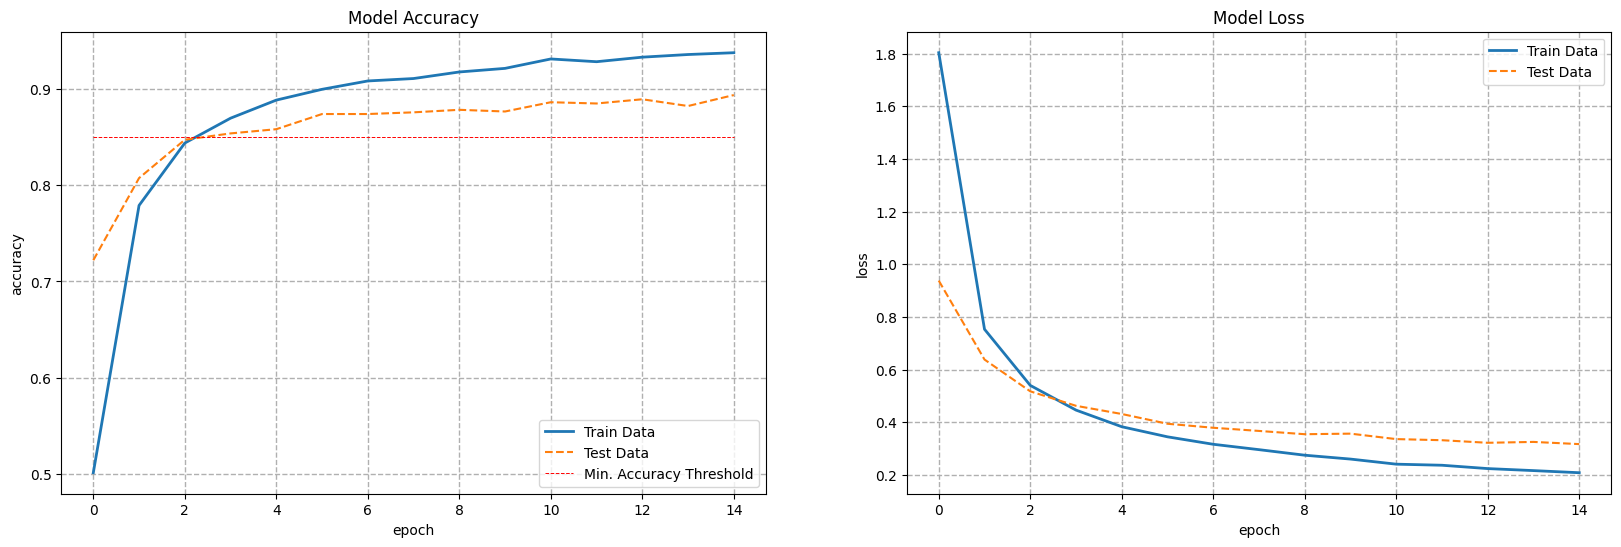

In [24]:
def plot_trained_model_history(trained_model,min_acc):
    acc     = trained_model.history['accuracy']
    val_acc = trained_model.history['val_accuracy']

    loss     = trained_model.history['loss']
    val_loss = trained_model.history['val_loss']

    plt.figure(figsize=(20, 6))

    length   = len(acc)
    min_acc  = [min_acc]*length

    # Grafik Nilai Akurasi
    plt.subplot(1, 2, 1)
    plt.title('Model Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(acc, label='Train Data',linewidth=2)
    plt.plot(val_acc, label='Test Data', linestyle='--')
    plt.plot(min_acc, label='Min. Accuracy Threshold',linestyle='--',color='red',linewidth=.7)
    plt.legend()
    plt.grid(linestyle='--', linewidth=1)

    # Grafik Nilai Loss
    plt.subplot(1, 2, 2)
    plt.title('Model Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss, label='Train Data',linewidth=2)
    plt.plot(val_loss, label='Test Data', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1)

    plt.show()

plot_trained_model_history(trained_model,0.85)

# 6. Save Model

In [27]:
## save model
model.save('custom_mobilenet_v2.h5')

In [30]:
## load the model
from tensorflow.keras.models import load_model

new_model = tf.keras.models.load_model(('custom_mobilenet_v2.h5'),
                                       custom_objects={'KerasLayer':hub.KerasLayer})

# 7. Backtesting and Visualization

In [31]:
import matplotlib.pyplot as plt

feature,target = next(iter(test_generator))
y_pred = new_model.predict(test_generator)
y_pred

fig,axes = plt.subplots(8,4,figsize=(24,32))
for img,label,pred,ax in zip(feature,target,y_pred,axes.flatten()):
    ax.imshow(img)
    label = label.argmax()
    pred  = pred.argmax()

    font = {"color":"g"} if label == pred else {"color":"r"}

    label_name,pred_name = target_names[label], target_names[pred]

    ax.set_title(f"Label : {label_name} | Pred : {pred_name}", fontdict=font)
    ax.axis("off");

Output hidden; open in https://colab.research.google.com to view.

# 8. Backtesting for New Uploaded Images

In [33]:
dict_class = {value:key for key, value in train_generator.class_indices.items()}

Saving check01.jpeg to check01.jpeg
1/1 [==============================] - 0s 21ms/step


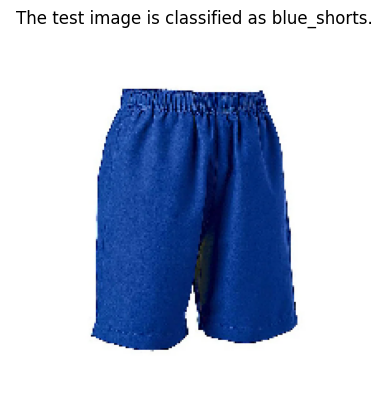

In [38]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size = (size[0],size[1]))

  x = img_to_array(img)/255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 32)

  plt.imshow(img)
  plt.axis("off")
  plt.title("The test image is classified as {}.".format(dict_class[classes.argmax()]))
  plt.show()